In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import TimeSeriesDifferentiator
from sklearn.metrics import mean_absolute_error

In [2]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()
data.head(4)

Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
Freq: MS, Name: Passengers, dtype: int64

In [49]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Date', length=144, freq='MS')

In [3]:
# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data.to_numpy())
data_diff = pd.Series(data_diff, index=data.index).dropna()
data_diff.head(4)

Date
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
Freq: MS, dtype: float64

Train dates : 1949-01-01 00:00:00 --- 1955-12-01 00:00:00  (n=84)
Test dates  : 1956-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=60)


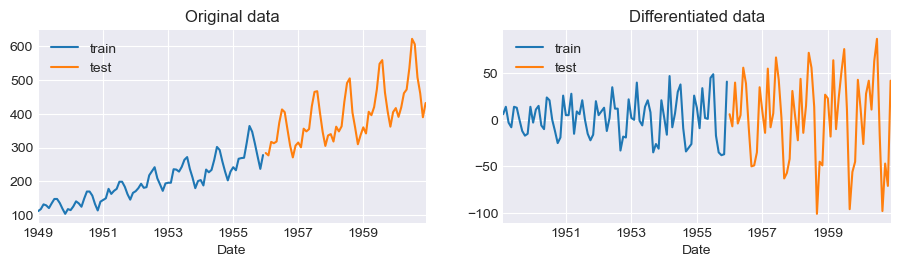

In [4]:
# Data partition train-test
# ==============================================================================
end_train = '1955-12-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(11, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

In [47]:
data

Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, Length: 144, dtype: int64

In [44]:
predictions_rf

1956-01-01    304.96
1956-02-01    295.92
1956-03-01    322.37
1956-04-01    328.54
1956-05-01    329.75
1956-06-01    367.40
1956-07-01    408.61
1956-08-01    388.16
1956-09-01    354.61
1956-10-01    321.36
1956-11-01    290.91
1956-12-01    328.55
1957-01-01    354.21
1957-02-01    346.51
1957-03-01    371.01
1957-04-01    384.81
1957-05-01    387.37
1957-06-01    420.87
1957-07-01    462.13
1957-08-01    438.83
1957-09-01    405.42
1957-10-01    371.92
1957-11-01    341.51
1957-12-01    378.83
1958-01-01    404.54
1958-02-01    397.94
1958-03-01    422.57
1958-04-01    447.62
1958-05-01    451.13
1958-06-01    481.38
Freq: MS, Name: pred, dtype: float64

Steps: 30


Training + Prediction Passes: 100%|██████████| 8/8 [00:03<00:00,  2.17batch/s]

Error (MAE) Random Forest: 30.01
Error (MAE) XGBoost: 23.89
Error (MAE) TabPFN: 28.91


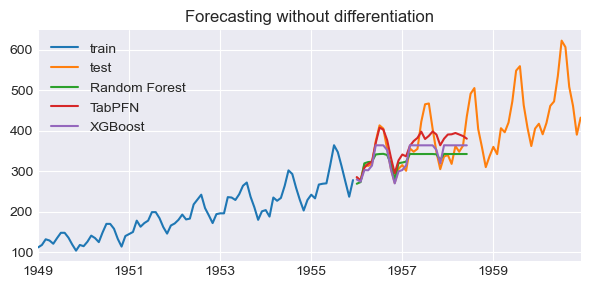

In [28]:
from tabpfn import TabPFNRegressor

tabpfn_regressor = TabPFNRegressor()

# Forecasting without differentiation
# ==============================================================================
# steps = len(data.loc[end_train:])
steps = 30
print(f"Steps: {steps}")

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 12
                )

forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 12
                )

forecaster_tabpfn = ForecasterAutoreg(
                    regressor = tabpfn_regressor,
                    lags      = 12
                )

# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])
forecaster_tabpfn.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)
predictions_tabpfn = forecaster_tabpfn.predict(steps=steps)

# Error
end_date = str(pd.to_datetime(end_train) + pd.DateOffset(months=steps))
error_rf = mean_absolute_error(data.loc[end_train:end_date], predictions_rf)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")

error_gb = mean_absolute_error(data.loc[end_train:end_date], predictions_gb)
print(f"Error (MAE) XGBoost: {error_gb:.2f}")

error_tabpfn = mean_absolute_error(data.loc[end_train:end_date], predictions_tabpfn)
print(f"Error (MAE) TabPFN: {error_tabpfn:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_tabpfn.plot(ax=ax, label='TabPFN')
predictions_gb.plot(ax=ax, label='XGBoost')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();

Steps: 30


Training + Prediction Passes: 100%|██████████| 8/8 [00:04<00:00,  1.77batch/s]

Error (MAE) Random Forest: 30.15
Error (MAE) XGBoost: 19.51
Error (MAE) TabPFN: 20.18


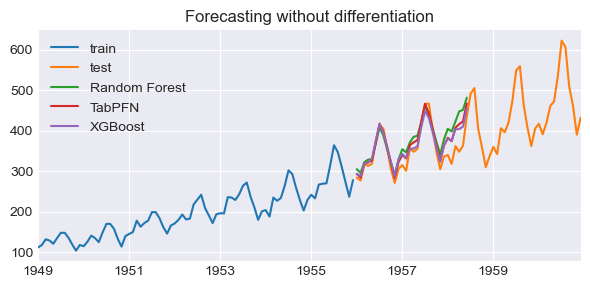

In [37]:
from tabpfn import TabPFNRegressor

tabpfn_regressor = TabPFNRegressor()

# Forecasting without differentiation
# ==============================================================================
# steps = len(data.loc[end_train:])
steps = 30
print(f"Steps: {steps}")

# Forecasters
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=963),
                    lags      = 12,
                    differentiation = 1,
                )

forecaster_gb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 12,
                    differentiation = 1,
                )

forecaster_tabpfn = ForecasterAutoreg(
                    regressor = tabpfn_regressor,
                    lags      = 12,
                    differentiation = 1,
                )

# Train
forecaster_rf.fit(data.loc[:end_train])
forecaster_gb.fit(data.loc[:end_train])
forecaster_tabpfn.fit(data.loc[:end_train])

# Predict
predictions_rf = forecaster_rf.predict(steps=steps)
predictions_gb = forecaster_gb.predict(steps=steps)
predictions_tabpfn = forecaster_tabpfn.predict(steps=steps)

# Error
end_date = str(pd.to_datetime(end_train) + pd.DateOffset(months=steps))
error_rf = mean_absolute_error(data.loc[end_train:end_date], predictions_rf)
print(f"Error (MAE) Random Forest: {error_rf:.2f}")

error_gb = mean_absolute_error(data.loc[end_train:end_date], predictions_gb)
print(f"Error (MAE) XGBoost: {error_gb:.2f}")

error_tabpfn = mean_absolute_error(data.loc[end_train:end_date], predictions_tabpfn)
print(f"Error (MAE) TabPFN: {error_tabpfn:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_rf.plot(ax=ax, label='Random Forest')
predictions_tabpfn.plot(ax=ax, label='TabPFN')
predictions_gb.plot(ax=ax, label='XGBoost')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();

Steps: 30


openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.
openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.
openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.
openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.


Loading checkpoint from /Users/shibinhoo/miniconda3/envs/tabpfn-2/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression.ckpt
Preprocessing config in new way
removed num_classes from differentiable_hyperparameters
Initializing Bar distribution
remove your triton_ln config, it is now parameter_free as default.
Initialized decoder for standard with (None, 5000)  and nout 5000
using feature positional embedding subspace
Loading checkpoint from /Users/shibinhoo/miniconda3/envs/tabpfn-2/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression.ckpt
Loading checkpoint from /Users/shibinhoo/miniconda3/envs/tabpfn-2/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression.ckpt
Loading checkpoint from /Users/shibinhoo/miniconda3/envs/tabpfn-2/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression.ckpt
Preprocessing config in new way
removed num_classes from differentiable_hyperparameters
Initializing Bar distribution
remove your triton_ln c

openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.
openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.
openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.
openml.config INFO  No config file found at /Users/shibinhoo/.openml/config, using default configuration.


Preprocessing config in new way
removed num_classes from differentiable_hyperparameters
Initializing Bar distribution
remove your triton_ln config, it is now parameter_free as default.
Preprocessing config in new way
removed num_classes from differentiable_hyperparameters
Initializing Bar distribution
remove your triton_ln config, it is now parameter_free as default.
Loading checkpoint from /Users/shibinhoo/miniconda3/envs/tabpfn-2/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression.ckpt
Loading checkpoint from /Users/shibinhoo/miniconda3/envs/tabpfn-2/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression.ckpt
Preprocessing config in new way
removed num_classes from differentiable_hyperparameters
Initializing Bar distribution
remove your triton_ln config, it is now parameter_free as default.
Initialized decoder for standard with (None, 5000)  and nout 5000
using feature positional embedding subspace
Initialized decoder for standard with (None, 5000)  a

Training + Prediction Passes:   0%|          | 0/8 [00:00<?, ?batch/s]

cancel nan borders


Training + Prediction Passes: 100%|██████████| 8/8 [00:04<00:00,  1.90batch/s]


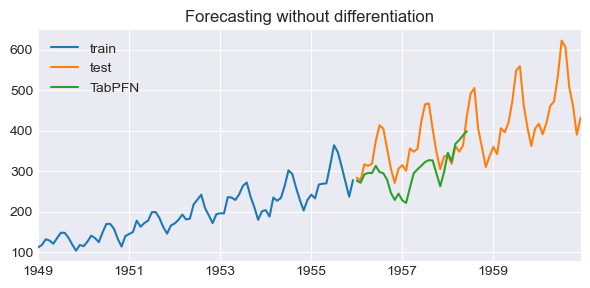

In [41]:
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from tabpfn import TabPFNRegressor

tabpfn_regressor = TabPFNRegressor()

# Forecasting without differentiation
# ==============================================================================
# steps = len(data.loc[end_train:])
steps = 30
print(f"Steps: {steps}")

# Forecasters
forecaster_tabpfn = ForecasterAutoregDirect(
                    regressor = tabpfn_regressor,
                    lags      = 12,
                    steps=steps,
                )

# Train
forecaster_tabpfn.fit(data.loc[:end_train])

# Predict
predictions_tabpfn = forecaster_tabpfn.predict(steps=steps)

# # Error
# end_date = str(pd.to_datetime(end_train) + pd.DateOffset(months=steps))
# error_rf = mean_absolute_error(data.loc[end_train:end_date], predictions_rf)
# print(f"Error (MAE) Random Forest: {error_rf:.2f}")

# error_gb = mean_absolute_error(data.loc[end_train:end_date], predictions_gb)
# print(f"Error (MAE) XGBoost: {error_gb:.2f}")

# error_tabpfn = mean_absolute_error(data.loc[end_train:end_date], predictions_tabpfn)
# print(f"Error (MAE) TabPFN: {error_tabpfn:.2f}")

# Plot
fig, ax = plt.subplots(figsize=(7, 3), sharex=True, sharey=True)
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_tabpfn.plot(ax=ax, label='TabPFN')
ax.set_title(f'Forecasting without differentiation')
ax.set_xlabel('')
ax.legend();